## Description
The purpose of this notebook is to demonstrate the basic workings of a) the Learning in the Model Space (LiMS) Probabilistic Hough Transform (PHT) classifier
and b) the subspace learning algorithm, both presented in "Discriminative subspace learning for model- and data-driven discovery" by J. Norden et al.


=More description? 
The notebook shows how one can generate artifical data for a prednisone-prednisolone conversion problem.
From the generated time series data, sampling of posteriors is carried out.
Based on the 





The notebook is structured as follows
1. Data generation and visualization
2. Sampling of posteriors
3. Density estimation
4. Evaluating the LiMS PHT classifier
5. Subspace learning

Depending on the device available, the sampling of posteriors (Step 3) and performing the density estimation (Step 4) may take quite a while.
Therefore, the number of example timeseries created is restricted to 5 examples for steps 1, 2 and 3.
Before step 4, the user can choose to either proceed with the data set thus created (5 examples per class) or
load a dataset from a previous run of sampling with 40 examples per class (as reported in the paper).

In [1]:
# import relevant packages and modules
import numpy as np
from src.dynamical_systems.prednisone_3D import Prednisone3D
from src.sampler import Sampler
from src.data_box import DataBox
from src.density_estimator import DensityEstimator
from src.lims_classifier import LiMSClassifier
import src.utility as utility
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from src.subspace_learner import SubspaceLearner

# set random seed for reproducibility
np.random.seed(0)

---
## 1. Data generation and visualization
---

In [2]:
# generate data set

model = Prednisone3D()

gen_data_opts = {
    'num_examples': np.array([5, 5]),                        # Array with number of examples per class
    'init_cond': np.array([0, 0]),                           # Array holding intial condition for prednisone model (P0: prednisone in blood, L0: prednisolone in blood)
    't_lim': np.array([0, 240]),                             # Array holding minimal and maximal time values t_min and t_max
    'obs_regularity': np.array([10, 15]),                    # Array holding the minimum and maximum amount of time steps between t_min and t_max
    'obs_noise_cov': np.diag([20, 20]),                      # Array holding the cov. matrix for observational noise to be added to P and L trajectories
    'scale_spiral': 0.15,                                    # Number giving the scaling of the sprial structure that characterizes the class-conditionals
    'sigma_orth_comp': 0.05,                                 # Positive Number, giving the std. of Gaussian components orthogonal to spiral
    'shift_vec': np.array([0.1, 0.1, 0.1]),                  # Array giving the shift of the spiral center 
    'rot_angles': [-np.pi / 4, 0., 0.]                       # List containing the x, y and z rotation angles
}

data_box_t = model.gen_timeseries_data_rotated_spiral(gen_data_opts)

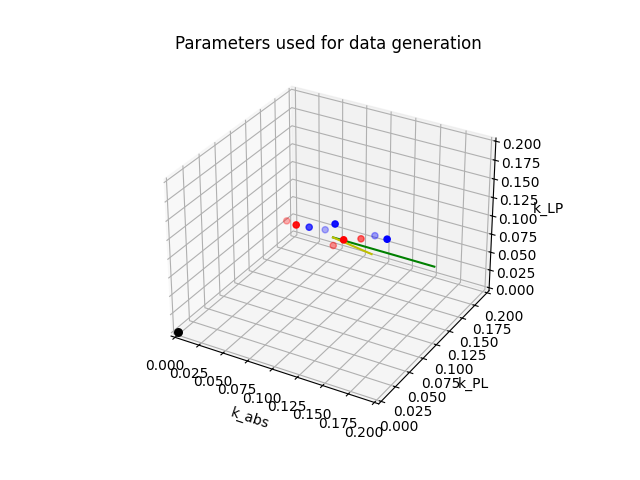

In [3]:
# visualize parameters

# get labels and class indices
labels = data_box_t.get_labels()
idx_C0 = [idx for idx, value in enumerate(labels) if value == 0]
idx_C1 = [idx for idx, value in enumerate(labels) if value == 1]

# get parameters and separate by class
parameters = data_box_t.get_parameters()
params_C0 = parameters[idx_C0, :]
params_C1 = parameters[idx_C1, :]

# get true subspace
subspace = data_box_t.get_subspace()
center = subspace['center']
v1 = 0.1 * subspace['v1']
v2 = 0.1 * subspace['v2']

# visualize the groundtruth parameters
%matplotlib widget 

# create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(params_C0[:, 0], params_C0[:, 1], params_C0[:, 2], c='blue')
ax.scatter(params_C1[:, 0], params_C1[:, 1], params_C1[:, 2], c='red')

ax.plot([center[0], center[0] + v1[0]], [center[1], center[1] + v1[1]], zs=[center[2], center[2] + v1[2]], color='g')
ax.plot([center[0], center[0] + v2[0]], [center[1], center[1] + v2[1]], zs=[center[2], center[2] + v2[2]], color='y')

ax.scatter(0, 0, 0, color='k', linewidths=2)

ax.set_xlim([0, 0.2])
ax.set_ylim([0, 0.2])
ax.set_zlim([0, 0.2])

ax.set_xlabel('k_abs')
ax.set_ylabel('k_PL')
ax.set_zlabel('k_LP')
ax.set_title('Parameters used for data generation')

plt.show()

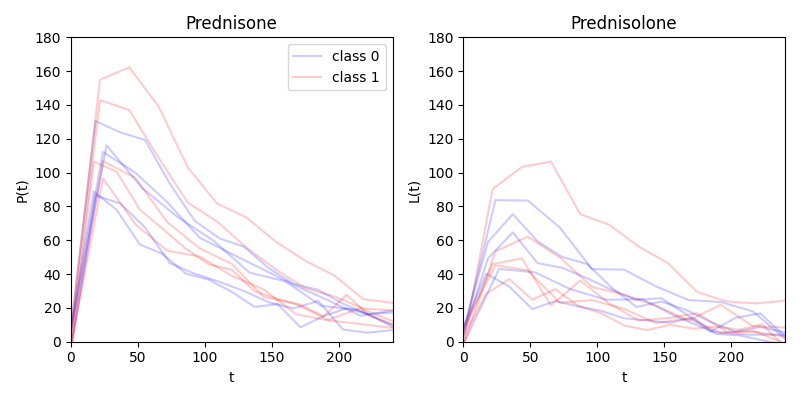

In [4]:
# plot generated time series data

timeseries = data_box_t.get_timeseries()

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

for i in range(len(idx_C0)):
    if i == 0:
        label = label='class 0'
    else:
        label = None
    axs[0].plot(timeseries[idx_C0[i]][0, :], timeseries[idx_C0[i]][1, :], color='blue', alpha=0.2, label=label)
    axs[1].plot(timeseries[idx_C0[i]][0, :], timeseries[idx_C0[i]][2, :], color='blue', alpha=0.2)


for i in range(len(idx_C1)):
    if i == 0:
        label = label='class 1'
    else:
        label = None
    axs[0].plot(timeseries[idx_C1[i]][0, :], timeseries[idx_C1[i]][1, :], color='red', alpha=0.2, label=label)
    axs[1].plot(timeseries[idx_C1[i]][0, :], timeseries[idx_C1[i]][2, :], color='red', alpha=0.2)


axs[0].set_xlabel('t')
axs[0].set_ylabel('P(t)')
axs[0].set_xlim(0, 240)
axs[0].set_ylim(0, 180)
axs[0].set_title('Prednisone')
axs[0].legend()

axs[1].set_xlabel('t')
axs[1].set_ylabel('L(t)')
axs[1].set_xlim(0, 240)
axs[1].set_ylim(0, 180)
axs[1].set_title('Prednisolone')


plt.tight_layout()
plt.show()

---
## 2. Sampling of posteriors
---

In [5]:
# define sampler and run (~ 1 minute runtime)

# set sampler options
sampler_opts = {
    'type': 'nested_sampling',
    'num_live_points': 50,
    'parallel': True,
    'num_CPU': 8,
    'weighted': False
}

# define sampler object
sampler = Sampler(data_box_t, sampler_opts)

# run sampling
data_box_ts = sampler.run_sampling()

iter: 618 | +50 | bound: 17 | nc: 1 | ncall: 3130 | eff(%): 21.688 | loglstar:   -inf < -71.099 <    inf | logz: -80.480 +/-  0.393 | dlogz:  0.001 >  0.059                                          

In [ ]:
# visualize created samples

num_bins = 100
smoothness = 1
colours = ['blue', 'red', 'green']
labels=[r"$m_{1}$",
        r"$m_{2}$",
        r"$s_{1}$",
        r"$s_{2}$"]
limits = np.array([[0, 100],
                   [0, 100],
                   [-1, 1],
                   [-1, 1],])

title = 'Gravitational Waves'
legend = ['NS - BH / NS - NS', 'Small BH - Small BH', 'Large BH - Large BH ']
figsize = (15, 6)

figure = data_box_ts.plot_posterior_samples(
                                            num_bins = 100, 
                                            smoothness = 1, 
                                            colours = ['blue', 'red'],
                                            labels=[r"$k_{abs}$", r"$k_{PL}$", r"$k_{LP}$"], 
                                            limits=np.array([[0, 0.2],
                                                             [0, 0.2],
                                                             [0, 0.2]]), 
                                            title='Samples', 
                                            legend=['class 0', 'class 1'], 
                                            figsize=(10, 10)
                                            )

---
## 3. Density estimation
---

In [6]:
# create density estimates with spherical covariance structure (~ 4 seconds)

# set density estimation options
density_est_opts = {
    'type':             'bayesian_gaussian_mixture',
    'covariance_type':                  'spherical',    # 'full' 'spherical' 
    'n_components':                               5,    # 20 
    'n_init' :                                   20,    # 20
    'max_iter':                                 500,    # 500
    'trim_percent':                            0.99
}

# define density estimator object
dens_estimator = DensityEstimator(data_box_ts, density_est_opts)

# run density estimation
data_box_spherical = dens_estimator.run_density_estimation()

Bayesian Gaussian Mixture: 1 / 10
Bayesian Gaussian Mixture: 2 / 10
Bayesian Gaussian Mixture: 3 / 10
Bayesian Gaussian Mixture: 4 / 10
Bayesian Gaussian Mixture: 5 / 10
Bayesian Gaussian Mixture: 6 / 10
Bayesian Gaussian Mixture: 7 / 10
Bayesian Gaussian Mixture: 8 / 10
Bayesian Gaussian Mixture: 9 / 10
Bayesian Gaussian Mixture: 10 / 10


In [ ]:
# visualize density estimates
plot_opts = {
'x_lim':        np.array([0, 0.2]),
'y_lim':        np.array([0, 0.2]),
'z_lim':        np.array([0, 0.2]),
'x_label':      'k_ex',
'y_label':      'k_PL',
'z_label':      'k_LP'
}

utility.plot_spirals(data_box_spherical, plot_opts)

---
## 4. Evaluating the LiMS PHT classifier
---
We now may proceed with the data we have created or load a data box from file which contains 40 examples per class.

In [9]:
# load data box with 40 examples per class or keep the one already created
load_data_from_file = True  # set to False to use new data
if load_data_from_file:
    # load data from previous sampling and density estimation
    data_box_spherical = DataBox()
    data_box_spherical = data_box_spherical.load_data('/interim/prednisone_3D_spherical_finite_mixture.pckl')

In [10]:
# preprocess the data

# make 50/50 train and test split
labels = data_box_spherical.get_labels()
skf = StratifiedKFold(n_splits = 2, shuffle=True, random_state=0)
split1, split2 = skf.split(np.zeros(len(labels)), labels)
train_index = split1[0]
test_index = split1[1]
labels_train = labels[train_index]
labels_test = labels[test_index]
data_box_spherical_train = data_box_spherical.select_examples(train_index)
data_box_spherical_test = data_box_spherical.select_examples(test_index)

# apply apply standard-score transform as preprocessing
data_box_spherical_train_norm, means, std_devs = data_box_spherical_train.shift_and_scale_data()       # apply standard-score transform
data_box_spherical_test_norm, _, _ = data_box_spherical_test.shift_and_scale_data(means, std_devs)     # apply the same transform to test data

Finally, we evaluate the LiMS PHT classifier for the given data projected into the $(k_{PL},k_{LP})$-plane. This corresponds to a basis matrix 
$$\mathbf{V} = 
\begin{bmatrix}
0 & 0 \\
1 & 0 \\
0 & 1 \\
\end{bmatrix} $$

In [ ]:
# define PHT classifier and evaluate (this cell is calling on NUMBA and therefore takes longer the first time it is run ~15 seconds)

# define classifier
classifier = LiMSClassifier(None)

# define a class prior
class_prior = np.array([0.5, 0.5])

# define basis matrix
V = np.array([[0., 0.],
              [1., 0.],
              [0., 1.]])

# make predictions for training and test data
pht_predictions_train = classifier.eval_pht_classifier(data_box_spherical_train_norm, data_box_spherical_train_norm, class_prior, V)
pht_predictions_test = classifier.eval_pht_classifier(data_box_spherical_train_norm, data_box_spherical_test_norm, class_prior, V)

# evaluate accuracies and print
accuracy_train = utility.calc_accuracy(pht_predictions_train, labels_train)
accuracy_test = utility.calc_accuracy(pht_predictions_test, labels_test)

print('Micro avg. training accuracy: ' + str(accuracy_train[0]))
print('Macro avg. training accuracy: ' + str(accuracy_train[1]))
print('Micro avg. test accuracy:     ' + str(accuracy_test[0]))
print('Macro avg. test accuracy:     ' + str(accuracy_test[1]))


With 0.775 test accuracy, we can see that the classifier is doing reasonably well when the data is projected into the subspace spanned by $\mathbf{V}$.
In the following, we demonstrate our subspace learning to identify more discriminative subspaces.

---
## 5. Subspace learning
---

We now initialize a round of subspace learning with the $(k_{PL},k_{LP})$-plane as initial subspace and try to learn a more discriminating subspace.

In [ ]:
# set subspace learning options and run subspace learning (~ 25 seconds)

# set subspace learning options
subspace_learn_opts = {
    'subspace_dim':                                     2,      # positive integer      
    'cost_function':                'subspace_likelihood',      # 'subspace_likelihood', 'GLVQ', 'subspace_likelihood_gradient'
    'ssl_approx':                                    None,      # boolean, only makes a different if 'subspace_likelihood' is selected
    'opt_mode':                                   'batch',      # 'batch', 'iterative'
    'init_type':                                        V,      # 'PCA', 'random'
    'class_prior':                                 'flat',      # 'empirical', 'flat'
    'scipy_min_method':                            'BFGS',      # 'BFGS'
    'scipy_min_tol':                                1e-05,      # positive float
    'scipy_min_maxiter':                              100,      # positive int
    'scipy_min_disp':                                True,      # boolean
}

# run subspace learning
ssl = SubspaceLearner(data_box_spherical_train_norm, subspace_learn_opts)                                                          # spherical
data_box_spherical = ssl.run_subspace_learning()
subspace_learned = data_box_spherical.get_subspace_learned()

In [ ]:
# make predictions for training and test data
pht_predictions_train = classifier.eval_pht_classifier(data_box_spherical_train_norm, data_box_spherical_train_norm, class_prior, subspace_learned['V_opt'])
pht_predictions_test = classifier.eval_pht_classifier(data_box_spherical_train_norm, data_box_spherical_test_norm, class_prior, subspace_learned['V_opt'])

# evaluate accuracies and print
accuracy_train = utility.calc_accuracy(pht_predictions_train, labels_train)
accuracy_test = utility.calc_accuracy(pht_predictions_test, labels_test)

print('Micro avg. training accuracy: ' + str(accuracy_train[0]))
print('Macro avg. training accuracy: ' + str(accuracy_train[1]))
print('Micro avg. test accuracy:     ' + str(accuracy_test[0]))
print('Macro avg. test accuracy:     ' + str(accuracy_test[1]))

After a few iterations, the subspace learning algorithm converged. Indeed, we see that the classification performance is much improved when evaluating the PHT classifier on the learned subspace.